The aim is to detect light source objects and separate them from noise in telescopic images using different Deep Neural Networks. Data used is taken from a survey for NEOs (Near Earth Objects) by Lori Allen and collaborators using DECam on the Blanco 4m Telescope at CTIO. It comprises a stack of images taken over a period of 5 nights.

The results from these networks can be used to detect celestial bodies from images captured, and their trajectories given the images captured are consecutive. This can help in planet detection, finding new asteroids and other celestial bodies including comets etc.

In [95]:
!pip install astroML

import numpy as np
import matplotlib.pyplot as plt
from astroML.utils import split_samples
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import os
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Activation, ZeroPadding2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.layers import Input, Add
from tensorflow.keras.initializers import glorot_uniform
import tensorflow.keras.backend as K
from PIL import Image
import cv2

In [97]:
# Prints float numbers with a precision of 3
np.set_printoptions(precision=3)

K.set_image_data_format('channels_last')

In [ ]:
# Function to rescale the constrast in an image based on the noise
# Used while displaying the image and in the Neural Network
def normalize_image(image):
    sigmaG_coeff =  0.7413
    image = image.reshape(21, 21)
    # Calculates the 25, 50 & 75 percentile values of RGB, i.e., the values below which there are 25%, 50% & 75% of data points
    per25, per50, per75 = np.percentile(image, [25, 50, 75])
    sigmaG = sigmaG_coeff * (per75 - per25)
    # Sigma Clipping image [1]
    image[image < (per50 - 2*sigmaG)] = per50 - 2*sigmaG
    # Removing background
    image -= np.min(image)
    # Normalizing Pixel values
    image /= np.sum(image)

    return image

In [121]:
# Function to return Fourier Transformed Images after closing
# Takes Normalized Images Array as input and returns the array of operated images
def fourier_after_closing(norm_img_arr):
    kernel = np.ones((5, 5))
    new_arr = []

    for i in norm_img_arr:
      closing = cv2.morphologyEx(np.array(i), cv2.MORPH_CLOSE, kernel)
      img = Image.fromarray(closing.astype(np.float32))
      transformedImage = np.fft.fft2(img)
      shiftedTransform = np.fft.fftshift(transformedImage)
      magnitudeSpectrum = np.log(np.abs(shiftedTransform))

      new_arr.append(magnitudeSpectrum)

    return np.array(new_arr)

In [ ]:
# Function to plot an array of images
def plot_image_array(images, nrows=2, ncols=5, figsize=[8,4], nx=21, ny=21, title='',
                     subtitle=False, class_true=None, classes=None):

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.subplots_adjust(hspace=0, left=0.07, right=0.95, wspace=0.05, bottom=0.15)
    for indx in np.arange(nrows * ncols):
        i = int(indx / ncols)
        j = indx % ncols
        if (i == 0):
            ax[i][j].xaxis.set_major_formatter(plt.NullFormatter())
        if (j != 0):
            ax[i][j].yaxis.set_major_formatter(plt.NullFormatter())

        ax[i][j].imshow(images[indx].reshape(nx, ny), cmap='gray')
        if (subtitle == True):
            ax[i][j].set_title('True Class: %i, Predicted Class: %i\n  Prob Class 1 %e ' %(np.argmax(class_true[indx]), np.argmax(classes[indx]), classes[indx, 1]))

    fig.suptitle(title)
    ax[0][0].set_ylabel('$y$')
    ax[nrows-1][int(ncols/2)].set_xlabel('$x$')

In [ ]:
# Function to plot the confusion matrix properly
def plot_confusion_matrix(y_true, y_pred, normalize=False, title=None, cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)

    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotating the tick labels and aligning them
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    plt.ylim([1.5, -.5])

    # Loop over data dimensions and create text annotations.
    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()

In [ ]:
# Function to plot the training and validation history for a network
def plot_model_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    ax[0].plot(np.arange(n_epochs), loss, label='Training Loss')
    ax[0].plot(np.arange(n_epochs), val_loss, label='Validation Loss')
    ax[0].set_title('Loss Curves')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')

    ax[1].plot(np.arange(n_epochs), acc, label='Training Accuracy')
    ax[1].plot(np.arange(n_epochs), val_acc, label='Validation Accuracy')
    ax[1].set_title('Accuracy Curves')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')

In [ ]:
# Function to reshape arrays for compatibility with Keras
def reshape_arrays(data, labels):
    data = data.reshape(-1, 21, 21, 1)
    labels = to_categorical(labels)
    return data, labels

In [ ]:
# Function to return a simple NN, with 2 dense layers of 30 neurons and an output layer
def simple(input_shape=(21, 21, 1), n_classes=2):

    model = tf.keras.models.Sequential()

    # Input is of 21x21 images with 1 channel, i.e., a (21, 21, 1) tensor
    # 2 dense fully connected layers
    model.add(tf.keras.layers.Dense(30, input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.Dense(30, activation='relu'))

    # Output layer for classification
    model.add(tf.keras.layers.Flatten())
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation))

    return model

In [ ]:
# Function to return model using Batch Normalization
def simpleBN(input_shape=(21, 21, 1), n_classes: int = 2):

    model = tf.keras.models.Sequential()

    # 2 dense fully connected layers
    model.add(tf.keras.layers.Dense(30, input_shape=input_shape, activation='relu'))
    model.add(tf.keras.layers.Dense(30, activation='relu'))

    # Batch-Normalization Layer
    model.add(BatchNormalization(axis = 3))

    # Output layer for classification
    model.add(tf.keras.layers.Flatten())
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation))

    return model

In [ ]:
# Function to return a VGG model network
def vgg6(input_shape=(21, 21, 1), n_classes: int = 2):

    model = tf.keras.models.Sequential(name='VGG6')

    # 16 convolution filters of size 3x3 each
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))
    model.add(tf.keras.layers.Conv2D(16, (3, 3), activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.25))

    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu'))

    model.add(BatchNormalization(axis = 3))

    model.add(MaxPooling2D(pool_size=(4, 4)))
    model.add(tf.keras.layers.Dropout(0.25))  # Dropout layer to avoid overfitting

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(256, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))

    # Output layer for classification
    activation = 'sigmoid' if n_classes == 1 else 'softmax'
    model.add(tf.keras.layers.Dense(n_classes, activation=activation))

    return model

In [96]:
# Identity Block for ResNet 50
def identity_block(X, f, filters, stage, block):

    # Retrieving Filters
    F1, F2, F3 = filters

    X_copy = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1, 1), padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)

    # Shortcut value to main path
    X = Add()([X, X_copy])
    X = Activation('relu')(X)

    return X

# Convolutional Block for ResNet 50
def convolutional_block(X, f, filters, stage, block, s = 2):

    # Retrieve Filters
    F1, F2, F3 = filters

    X_copy = X

    # First component of main path
    X = Conv2D(F1, (1, 1), strides = (s,s), kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3)(X)

    # Shortcut Path
    X_copy = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', kernel_initializer = glorot_uniform(seed=0))(X_copy)
    X_copy = BatchNormalization(axis = 3)(X_copy)

    # Shortcut value to main path
    X = Add()([X, X_copy])
    X = Activation('relu')(X)

    return X

# Function to return ResNet 50 model network
def ResNet50(input_shape=(21, 21, 1), classes=2):

    # Defining the input as a tensor
    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # Output Layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)

    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [109]:
import os
import requests

files = {'noise': ('stamps_noise.npy', '1UT2BCf-IDUEpvTmcU4bq6nDcY3Ayw5vJ'),
         'sources': ('stamps_sources.npy', '1cZaMCA0z_nPX6GB_meLGouwOidEROcwc')}

for name, file_id in files.values():
    if not os.path.exists(name):
        print(f"Downloading file {name}.")

        url = f"https://docs.google.com/uc?export=download&id={file_id}&confirm=t"
        response = requests.post(url)
        with open(name, 'wb') as file:
            file.write(response.content)
    print(f"File {name} is downloaded")

print('\nFinished obtaining all data!')

File stamps_noise.npy is downloaded
File stamps_sources.npy is downloaded

Finished obtaining all data!


Data loaded successfully!



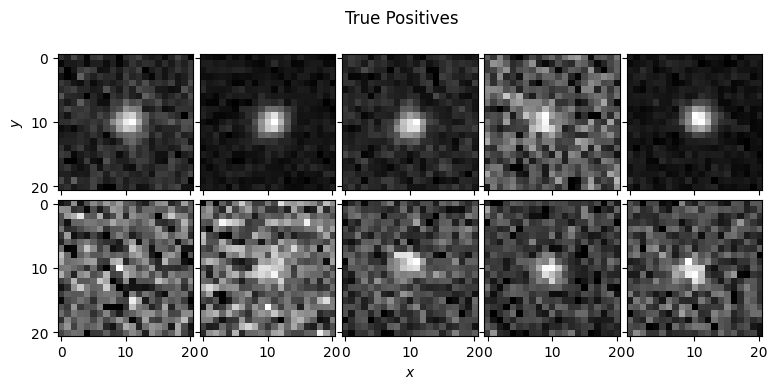

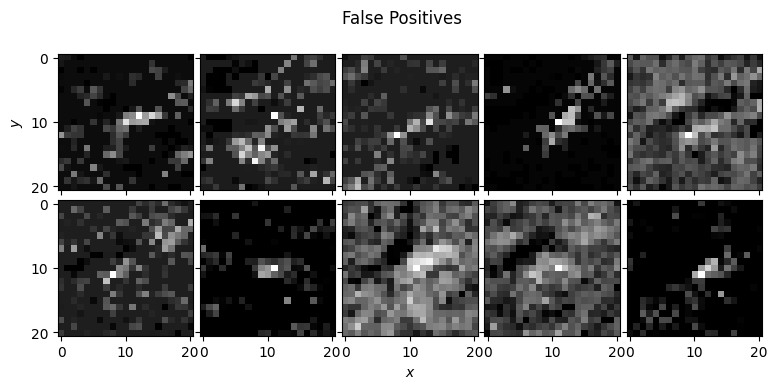

In [122]:
# Loading the data from ".npy" binary files
files = {'noise': 'stamps_noise.npy', 'sources': 'stamps_sources.npy'}

sources = np.load(files['sources'])  # These are the True Positives used for training
noise = np.load(files['noise'])  # These are the False Positives used for training

print('Data loaded successfully!\n')

# Normalizing the images
point_source_stamps = []
no_point_source_stamps = []
for image in sources:
    point_source_stamps.append(normalize_image(image))
for image in noise:
    no_point_source_stamps.append(normalize_image(image))

# Plotting sample of original images
plot_image_array(point_source_stamps, title='True Positives')
plot_image_array(no_point_source_stamps, title='False Positives')

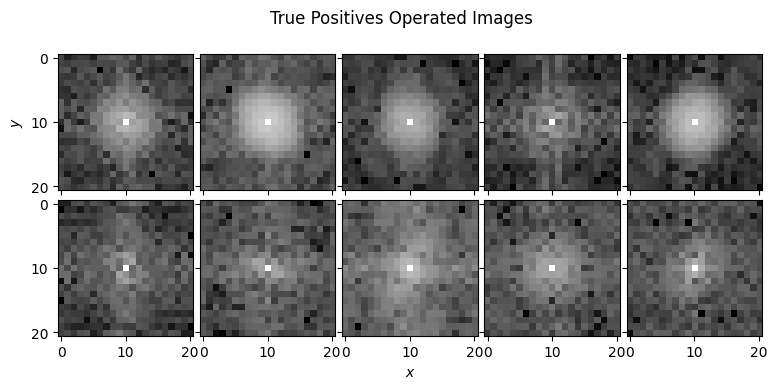

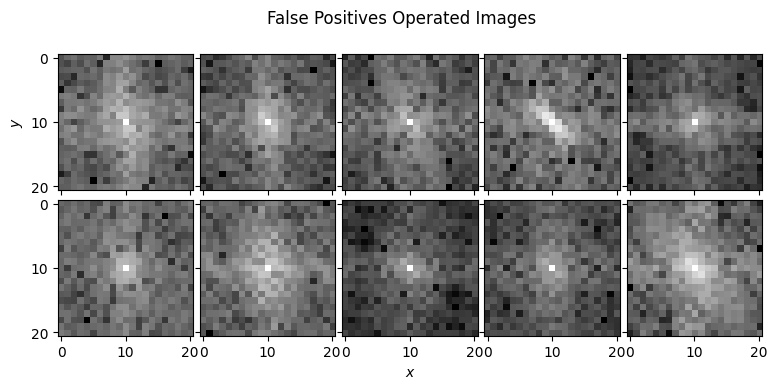

In [123]:
# Fourier Transformed operated images
f_point_source_stamps = fourier_after_closing(point_source_stamps)
f_no_point_source_stamps = fourier_after_closing(no_point_source_stamps)

# Plotting sample of operated images
plot_image_array(f_point_source_stamps, title='True Positives Operated Images')
plot_image_array(f_no_point_source_stamps, title='False Positives Operated Images')

In [124]:
# Combine the data and making the dataset
input_stamps = np.vstack([no_point_source_stamps, point_source_stamps])
stamp_class = np.zeros(len(no_point_source_stamps) + len(point_source_stamps))
stamp_class[len(no_point_source_stamps):] = 1 # 0 for noise, 1 for a star

# Splitting the data into training, validation and test datasets using astroML function
(data_train, data_val, data_test), (class_train, class_val, class_test) = split_samples(input_stamps, stamp_class,
                                                                                        [0.7, 0.1, 0.2])  # Numbers indicate the fractions of sources in each class
data_train, class_train = reshape_arrays(data_train, class_train)
data_val, class_val = reshape_arrays(data_val, class_val)
data_test, class_test = reshape_arrays(data_test, class_test)

print ('\nNumber of samples in:\n Training dataset = {}\n Test dataset = {}\n Validation dataset = {}'.format(data_train.shape[0], data_test.shape[0], data_val.shape[0]))


Number of samples in:
 Training dataset = 76666
 Test dataset = 21905
 Validation dataset = 10952


In [125]:
# Combine the data and making the dataset
f_input_stamps = np.vstack([f_no_point_source_stamps, f_point_source_stamps])
f_stamp_class = np.zeros(len(f_no_point_source_stamps) + len(f_point_source_stamps))
f_stamp_class[len(f_no_point_source_stamps):] = 1 # 0 for noise, 1 for a star

# Splitting the data into training, validation and test datasets using astroML function
(f_data_train, f_data_val, f_data_test), (f_class_train, f_class_val, f_class_test) = split_samples(f_input_stamps, f_stamp_class,
                                                                                        [0.7, 0.1, 0.2])  # Numbers indicate the fractions of sources in each class
f_data_train, f_class_train = reshape_arrays(f_data_train, f_class_train)
f_data_val, f_class_val = reshape_arrays(f_data_val, f_class_val)
f_data_test, f_class_test = reshape_arrays(f_data_test, f_class_test)

print ('\nNumber of samples in:\n Training dataset = {}\n Test dataset = {}\n Validation dataset = {}'.format(f_data_train.shape[0], f_data_test.shape[0], f_data_val.shape[0]))


Number of samples in:
 Training dataset = 76666
 Test dataset = 21905
 Validation dataset = 10952


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 21, 21, 30)     │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 21, 21, 30)     │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 13230)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 2)              │        26,462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,452 (107.23 KB)

 Trainable params: 27,452 (107.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.5497 - loss: 0.6891 - val_accuracy: 0.5462 - val_loss: 0.6886
Epoch 2/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5463 - loss: 0.6886 - val_accuracy: 0.5462 - val_loss: 0.6883
Epoch 3/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5470 - loss: 0.6882 - val_accuracy: 0.5462 - val_loss: 0.6880
Epoch 4/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.5484 - loss: 0.6876 - val_accuracy: 0.5462 - val_loss: 0.6877
Epoch 5/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5480 - loss: 0.6874 - val_accuracy: 0.5462 - val_loss: 0.6874
Epoch 6/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5465 - loss: 0.6873 - val_accuracy: 0.5462 - val_loss: 0.6870
Epoch 7/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5493 - loss: 0.6864 - val_accuracy: 0.5462 - val_loss: 0.6867
Epoch 8/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5469 - loss: 0.6865 - val_accuracy: 0.

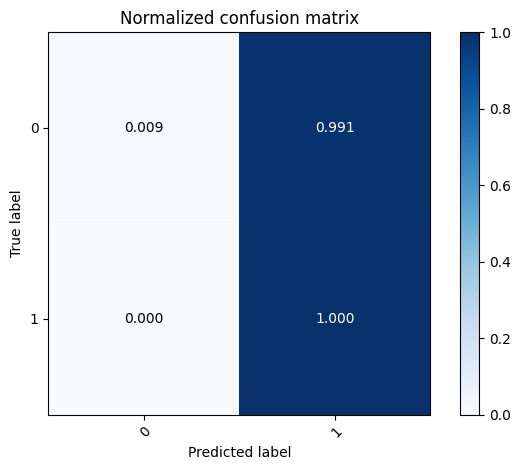

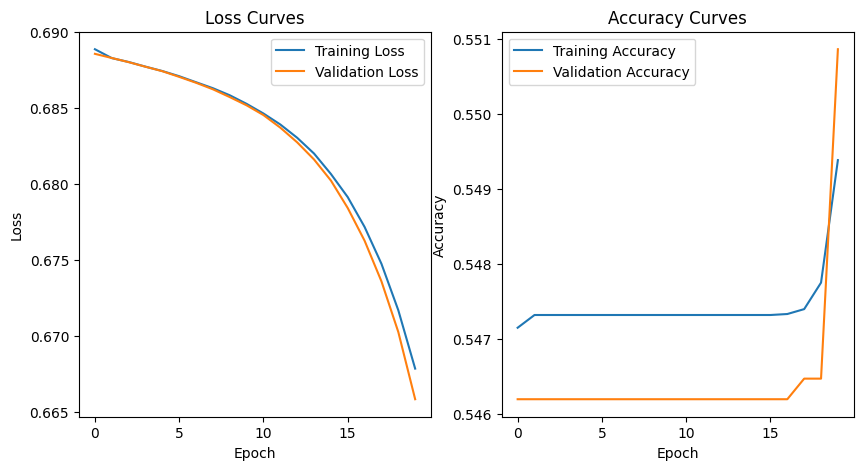

In [127]:
# Simple Model
simple_model = simple()
simple_model.summary()

# Training the simple model using Mini-Batch Gradient Descent
n_epochs = 20
batch_size = 100
simple_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
simple_model_history = simple_model.fit(data_train, class_train, epochs=n_epochs, batch_size=batch_size, verbose=1,
                                        validation_data=(data_val, class_val), shuffle=True)
classes = simple_model.predict(data_test)

# Plotting the confusion matrix
plot_confusion_matrix(np.argmax(class_test, axis=1), np.argmax(classes, axis=1), normalize=True, title='Normalized confusion matrix')

# Plotting the network's training history
plot_model_history(simple_model_history)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 21, 21, 30)     │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 21, 21, 30)     │           930 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_15 (Flatten)            │ (None, 13230)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 2)              │        26,462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,452 (107.23 KB)

 Trainable params: 27,452 (107.23 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.6604 - loss: 0.7195 - val_accuracy: 0.8178 - val_loss: 0.4037
Epoch 2/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7950 - loss: 0.4074 - val_accuracy: 0.8106 - val_loss: 0.4456
Epoch 3/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8042 - loss: 0.3835 - val_accuracy: 0.8243 - val_loss: 0.3821
Epoch 4/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8113 - loss: 0.3694 - val_accuracy: 0.7546 - val_loss: 0.3932
Epoch 5/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.8112 - loss: 0.3649 - val_accuracy: 0.7683 - val_loss: 0.3776
Epoch 6/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8178 - loss: 0.3533 - val_accuracy: 0.8290 - val_loss: 0.3502
Epoch 7/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8161 - loss: 0.3559 - val_accuracy: 0.8195 - val_loss: 0.3477
Epoch 8/20
767/767 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8160 - loss: 0.3543 - val_accuracy: 0.

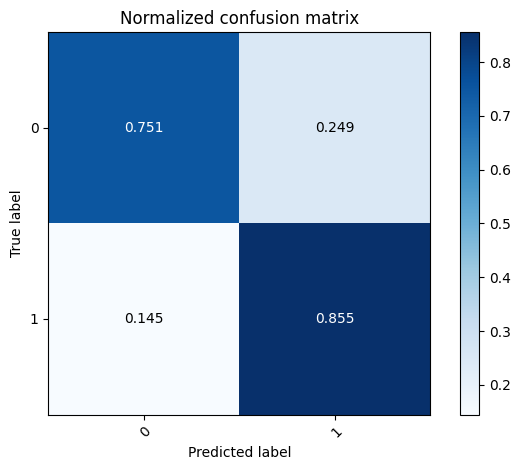

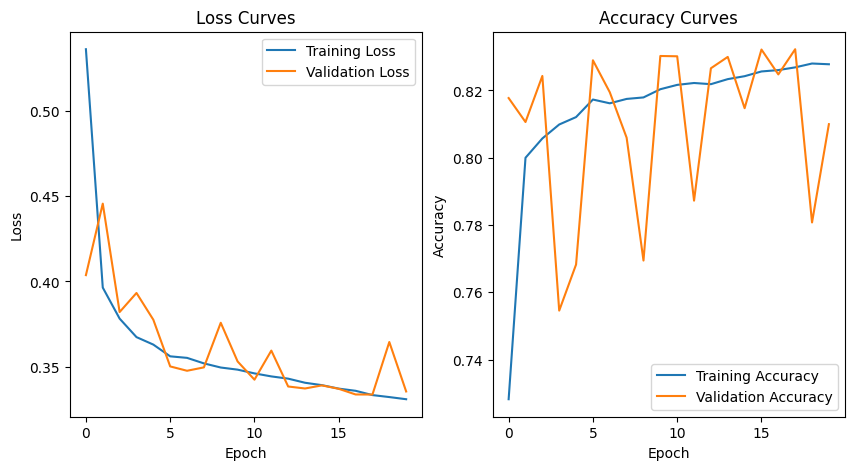

In [135]:
# Simple Model on Operated Images
f_simple_model = simple()
f_simple_model.summary()

# Training the simple model using Mini-Batch Gradient Descent
n_epochs = 20
batch_size = 100
f_simple_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
f_simple_model_history = f_simple_model.fit(f_data_train, f_class_train, epochs=n_epochs, batch_size=batch_size, verbose=1,
                                        validation_data=(f_data_val, f_class_val), shuffle=True)
classes = f_simple_model.predict(f_data_test)

# Plotting the confusion matrix
plot_confusion_matrix(np.argmax(f_class_test, axis=1), np.argmax(classes, axis=1), normalize=True, title='Normalized confusion matrix')

# Plotting the network's training history
plot_model_history(f_simple_model_history)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.5938 - loss: 0.6580 - val_accuracy: 0.8539 - val_loss: 0.6700
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8746 - loss: 0.5221 - val_accuracy: 0.8371 - val_loss: 0.5107
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8808 - loss: 0.4066 - val_accuracy: 0.8986 - val_loss: 0.3607
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8897 - loss: 0.3417 - val_accuracy: 0.8998 - val_loss: 0.3128
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8963 - loss: 0.3083 - val_accuracy: 0.9045 - val_loss: 0.2894
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9062 - loss: 0.2861 - val_accuracy: 0.9054 - val_loss: 0.2742
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9077 - loss: 0.2732 - val_accuracy: 0.9063 - val_loss: 0.2644
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9076 - loss: 0.2734 - val_accuracy: 0

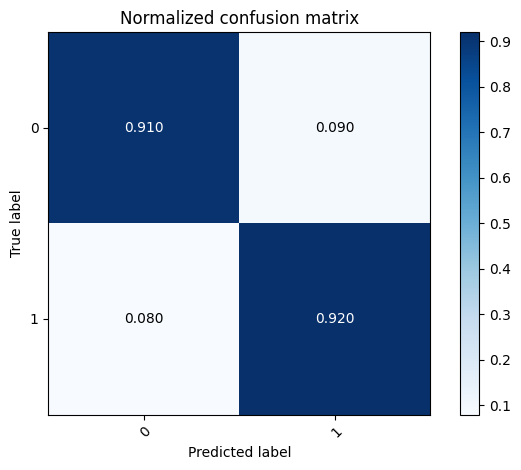

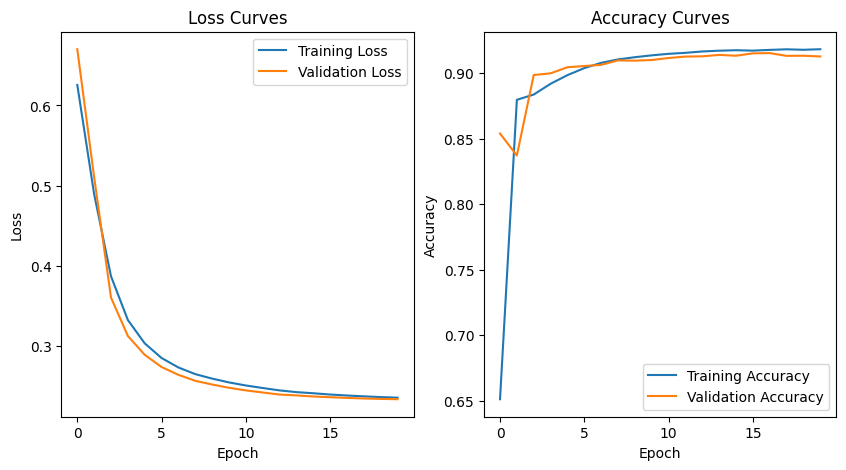

In [128]:
# Evaluating Batch Normalization model on original images
n_epochs = 20
simple_modelBN = simpleBN()
simple_modelBN.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
simple_modelBN_history = simple_modelBN.fit(data_train, class_train, epochs=n_epochs, batch_size=256, verbose=1,
                                        validation_data=(data_val, class_val), shuffle=True)
classes = simple_modelBN.predict(data_test)

# Plotting the confusion matrix
plot_confusion_matrix(np.argmax(class_test, axis=1), np.argmax(classes, axis=1), normalize=True, title='Normalized confusion matrix')

# Plotting the network's training history
plot_model_history(simple_modelBN_history)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7358 - loss: 0.8350 - val_accuracy: 0.8229 - val_loss: 0.3607
Epoch 2/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8162 - loss: 0.3555 - val_accuracy: 0.8236 - val_loss: 0.3676
Epoch 3/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8214 - loss: 0.3487 - val_accuracy: 0.7831 - val_loss: 0.3800
Epoch 4/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8244 - loss: 0.3440 - val_accuracy: 0.8326 - val_loss: 0.3383
Epoch 5/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8258 - loss: 0.3421 - val_accuracy: 0.8096 - val_loss: 0.4268
Epoch 6/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8251 - loss: 0.3456 - val_accuracy: 0.8321 - val_loss: 0.3356
Epoch 7/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8260 - loss: 0.3418 - val_accuracy: 0.8281 - val_loss: 0.3350
Epoch 8/20
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8244 - loss: 0.3449 - val_accuracy: 0

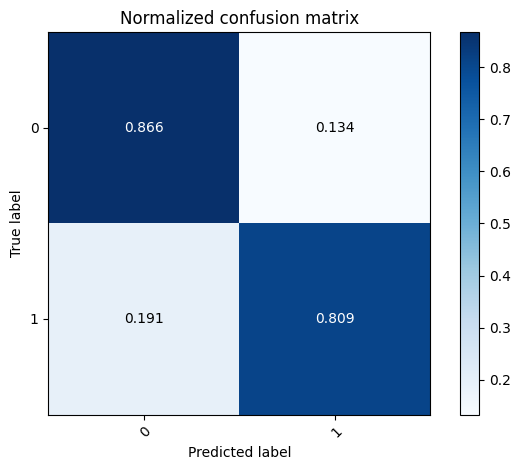

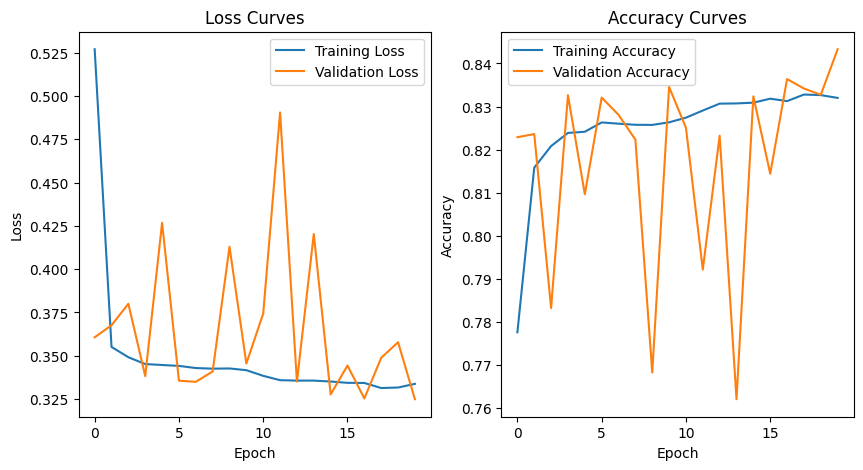

In [136]:
# Evaluating Batch Normalization model on operated images
n_epochs = 20
f_simple_modelBN = simpleBN()
f_simple_modelBN.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
f_simple_modelBN_history = f_simple_modelBN.fit(f_data_train, f_class_train, epochs=n_epochs, batch_size=256, verbose=1,
                                        validation_data=(f_data_val, f_class_val), shuffle=True)
classes = f_simple_modelBN.predict(f_data_test)

# Plotting the confusion matrix
plot_confusion_matrix(np.argmax(f_class_test, axis=1), np.argmax(classes, axis=1), normalize=True, title='Normalized confusion matrix')

# Plotting the network's training history
plot_model_history(f_simple_modelBN_history)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.5505 - loss: 0.6890 - val_accuracy: 0.5462 - val_loss: 0.6900
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5626 - loss: 0.6846 - val_accuracy: 0.5462 - val_loss: 0.6888
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5652 - loss: 0.6825 - val_accuracy: 0.5462 - val_loss: 0.6878
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5728 - loss: 0.6801 - val_accuracy: 0.5462 - val_loss: 0.6869
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5762 - loss: 0.6783 - val_accuracy: 0.5462 - val_loss: 0.6842
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5881 - loss: 0.6756 - val_accuracy: 0.5462 - val_loss: 0.6836
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5893 - loss: 0.6736 - val_accuracy: 0.6211 - val_loss: 0.6791
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6041 - loss: 0.6698 - val_accuracy: 0.5688 - v

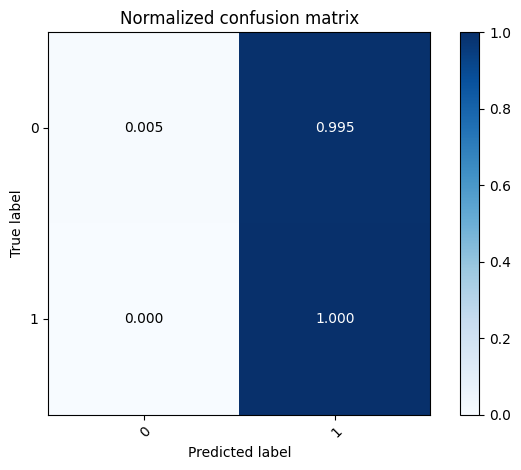

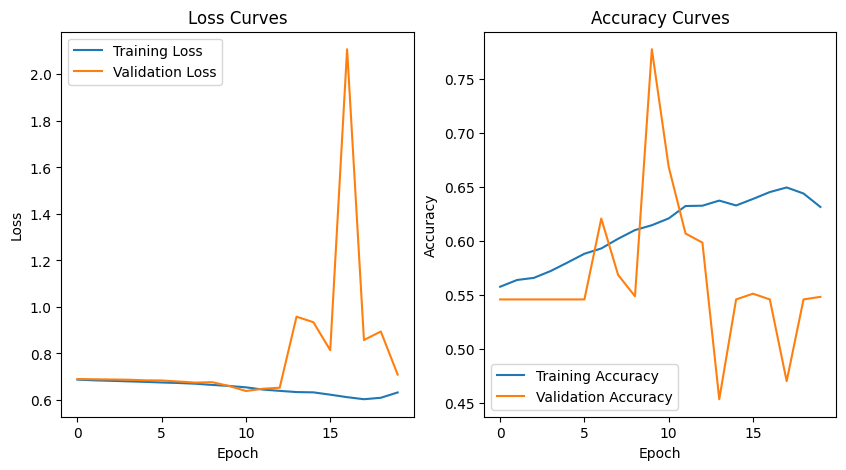

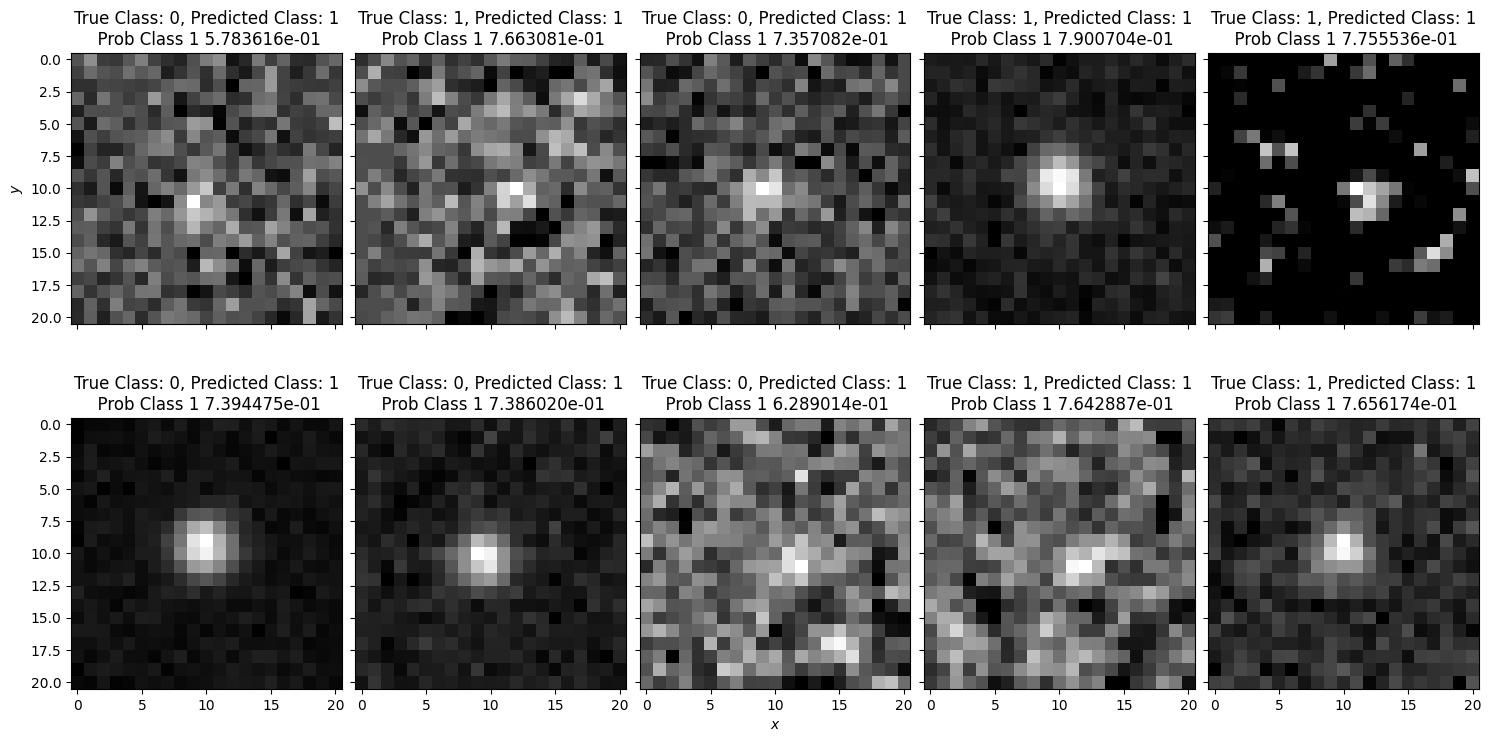

In [137]:
# Evaluating VGG6 model on original images
n_epochs = 20
vgg_model = vgg6()
vgg_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
vgg_model_history = vgg_model.fit(data_train, class_train, epochs=n_epochs, batch_size=1024, verbose=1,
                                  validation_data=(data_val, class_val), shuffle=True)
classes = vgg_model.predict(data_test)

# Plotting the confusion matrix
plot_confusion_matrix(np.argmax(class_test, axis=1), np.argmax(classes, axis=1), normalize=True, title='Normalized confusion matrix')

# Plotting the network's training history
plot_model_history(vgg_model_history)

# Plotting some sample classifications
plot_image_array(data_val, figsize=[16,10], subtitle=True, classes=classes, class_true=class_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
75/75 - 8s - 105ms/step - accuracy: 0.6419 - loss: 0.6959 - val_accuracy: 0.7921 - val_loss: 0.6548
Epoch 2/20
75/75 - 1s - 12ms/step - accuracy: 0.7464 - loss: 0.5084 - val_accuracy: 0.8002 - val_loss: 0.6244
Epoch 3/20
75/75 - 1s - 15ms/step - accuracy: 0.7720 - loss: 0.4523 - val_accuracy: 0.7918 - val_loss: 0.5816
Epoch 4/20
75/75 - 1s - 17ms/step - accuracy: 0.7832 - loss: 0.4246 - val_accuracy: 0.7869 - val_loss: 0.5332
Epoch 5/20
75/75 - 1s - 17ms/step - accuracy: 0.7884 - loss: 0.4102 - val_accuracy: 0.7176 - val_loss: 0.5496
Epoch 6/20
75/75 - 1s - 17ms/step - accuracy: 0.7929 - loss: 0.3985 - val_accuracy: 0.7966 - val_loss: 0.4292
Epoch 7/20
75/75 - 1s - 19ms/step - accuracy: 0.7951 - loss: 0.3916 - val_accuracy: 0.7741 - val_loss: 0.4346
Epoch 8/20
75/75 - 1s - 15ms/step - accuracy: 0.8003 - loss: 0.3830 - val_accuracy: 0.8169 - val_loss: 0.3578
Epoch 9/20
75/75 - 1s - 17ms/step - accuracy: 0.8029 - loss: 0.3759 - val_accuracy: 0.8181 - val_loss: 0.3538
Epoch 10/

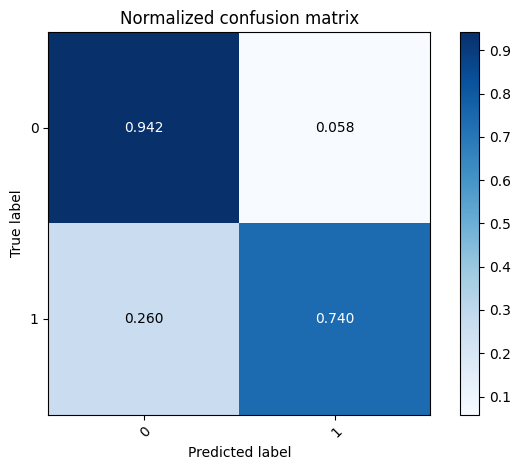

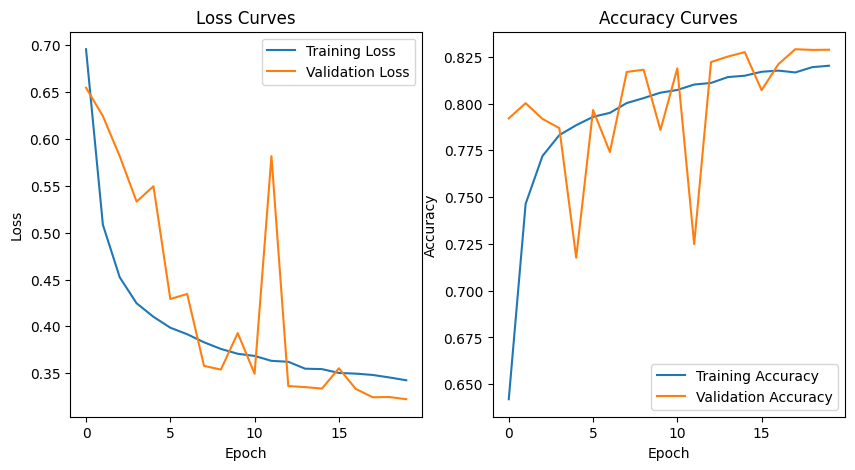

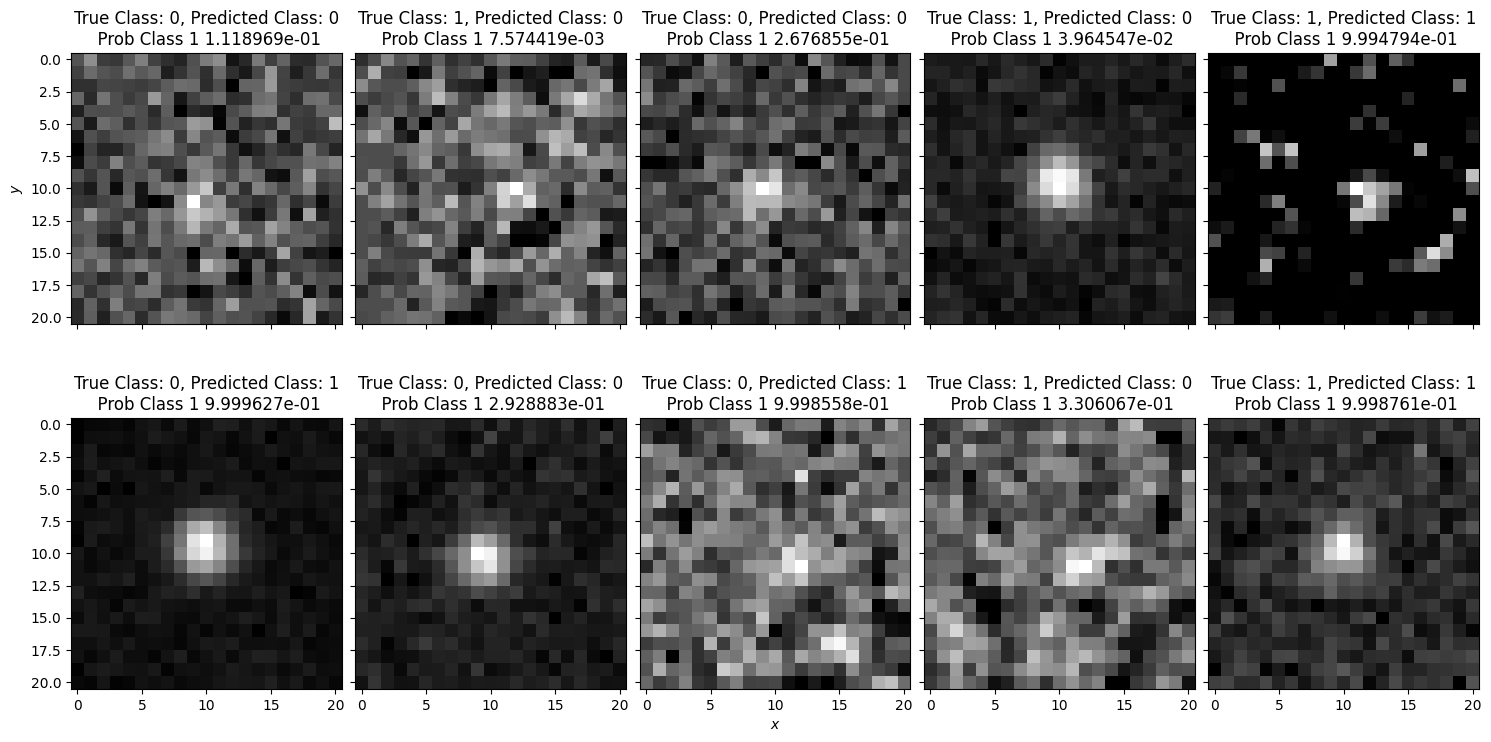

In [138]:
# Evaluating VGG6 model on operated images
n_epochs = 20
f_vgg_model = vgg6()
f_vgg_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
f_vgg_model_history = f_vgg_model.fit(f_data_train, f_class_train, epochs=n_epochs, batch_size=1024, verbose=2,
                                  validation_data=(f_data_val, f_class_val), shuffle=True)
classes = f_vgg_model.predict(f_data_test)

# Plotting the confusion matrix
plot_confusion_matrix(np.argmax(f_class_test, axis=1), np.argmax(classes, axis=1), normalize=True, title='Normalized confusion matrix')

# Plotting the network's training history
plot_model_history(f_vgg_model_history)

# Plotting some sample classifications
plot_image_array(data_val, figsize=[16,10], subtitle=True, classes=classes, class_true=class_test)

Epoch 1/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 71s 138ms/step - accuracy: 0.9141 - loss: 0.2903 - val_accuracy: 0.4538 - val_loss: 2.0593
Epoch 2/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 43s 65ms/step - accuracy: 0.9880 - loss: 0.0332 - val_accuracy: 0.6862 - val_loss: 1.3718
Epoch 3/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.9902 - loss: 0.0276 - val_accuracy: 0.9872 - val_loss: 0.0357
Epoch 4/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.9919 - loss: 0.0207 - val_accuracy: 0.9898 - val_loss: 0.0291
Epoch 5/5
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 64ms/step - accuracy: 0.9940 - loss: 0.0165 - val_accuracy: 0.9674 - val_loss: 0.1094
685/685 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step


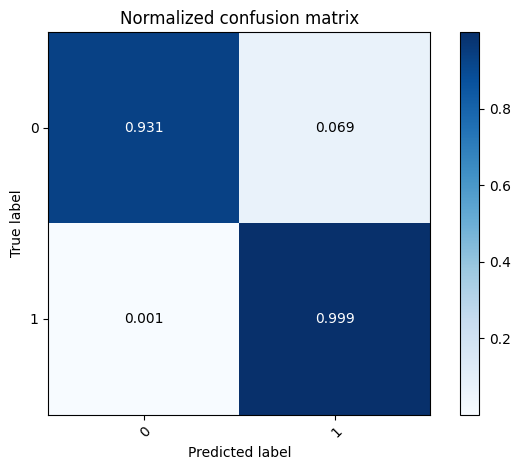

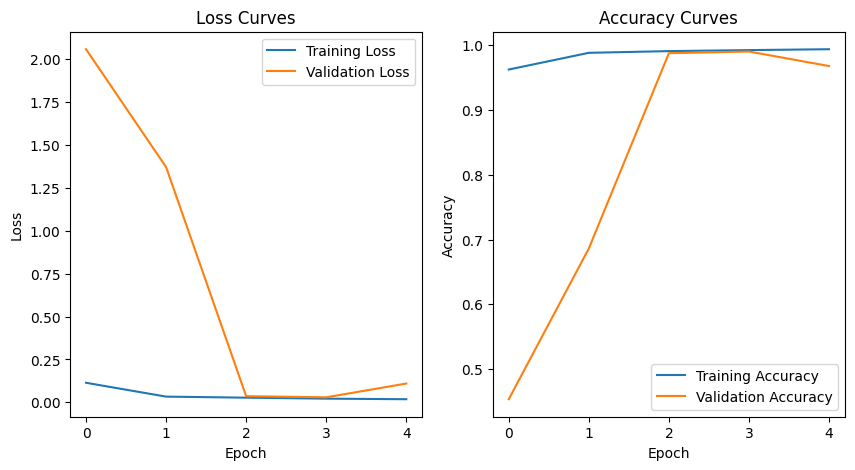

In [132]:
# Evaluating the ResNet 50 model on original images
resnet50_model = ResNet50()
resnet50_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
n_epochs = 5
resnet_model_history = resnet50_model.fit(data_train, class_train, epochs=n_epochs, batch_size=256, verbose=1,
                                          validation_data=(data_val, class_val), shuffle=True)

classes = resnet50_model.predict(data_test)

# Plotting the confusion matrix
plot_confusion_matrix(np.argmax(class_test, axis=1), np.argmax(classes, axis=1), normalize=True, title='Normalized confusion matrix')

# Plotting the network's training history
plot_model_history(resnet_model_history)

Epoch 1/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 65s 132ms/step - accuracy: 0.7686 - loss: 0.8357 - val_accuracy: 0.5532 - val_loss: 1.1926
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.8503 - loss: 0.2942 - val_accuracy: 0.7422 - val_loss: 0.4243
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 67ms/step - accuracy: 0.8581 - loss: 0.2783 - val_accuracy: 0.7373 - val_loss: 0.5969
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.8669 - loss: 0.2694 - val_accuracy: 0.8413 - val_loss: 0.3057
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.8692 - loss: 0.2620 - val_accuracy: 0.7100 - val_loss: 0.6494
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 21s 66ms/step - accuracy: 0.8698 - loss: 0.2617 - val_accuracy: 0.8440 - val_loss: 0.3205
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.8754 - loss: 0.2532 - val_accuracy: 0.8567 - val_loss: 0.2779
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 20s 66ms/step - accuracy: 0.8750 - loss: 0.2510 -

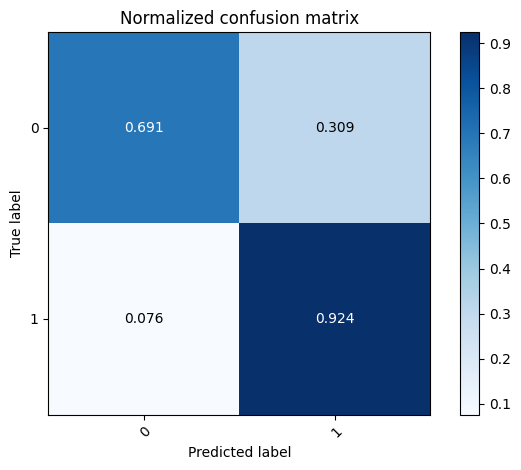

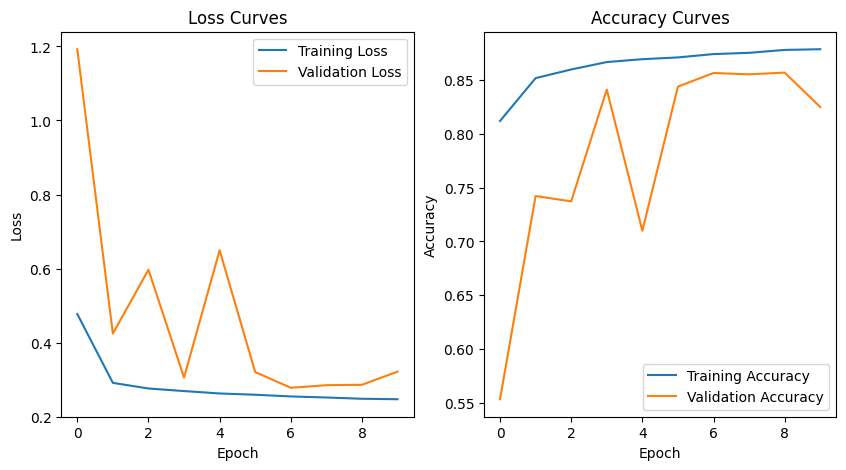

In [140]:
# Evaluating the ResNet 50 model on operated images
f_resnet50_model = ResNet50()
f_resnet50_model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
n_epochs = 10
f_resnet_model_history = f_resnet50_model.fit(f_data_train, f_class_train, epochs=n_epochs, batch_size=256, verbose=1,
                                          validation_data=(f_data_val, f_class_val), shuffle=True)

classes = f_resnet50_model.predict(f_data_test)

# Plotting the confusion matrix
plot_confusion_matrix(np.argmax(f_class_test, axis=1), np.argmax(classes, axis=1), normalize=True, title='Normalized confusion matrix')

# Plotting the network's training history
plot_model_history(f_resnet_model_history)

References:

1. AtroML Documentation
2. NumPy Documentation
3. OpenCV Documentation
4. https://www.gnu.org/software/gnuastro/manual/html_node/Sigma-clipping.html
5. https://www.astroml.org/astroML-notebooks/chapter9/astroml_chapter9_Deep_Learning_Classifying_Astronomical_Images.html
6. https://www.nature.com/articles/s42254-024-00743-y.epdf?sharing_token=uepzL03h6juODUhHsQx1pNRgN0jAjWel9jnR3ZoTv0N6ljBwTN5jK59kOF8dFbRdpc-f6rxs-bbAt700BtCmem_4wP2SzFeQ_FNr8-mNoypT46B_5kVdITgLx6xM_bTM8MCFA4Qcfoa0K8JxmHcVjT_I2Y7s7V15NTEqgM7SNHo%3D